In [3]:
# STEP 1 — Imports and initial setup for ResNet DeepFake Detector

import os
import random
import time
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix

# ✅ Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [4]:
# =====================================================
# STEP 1 — INSTALLS (optional for Kaggle) + IMPORTS
# =====================================================

# Kaggle already has PyTorch, torchvision, sklearn, tqdm preinstalled
# So no pip installs needed unless you run locally.

import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix

# =====================================================
# STEP 1 — SET DEVICE (CUDA)
# =====================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("✅ Using device:", DEVICE)
if DEVICE.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Count:", torch.cuda.device_count())
else:
    print("⚠️ Running on CPU — Go to 'Settings > Accelerator > GPU (P100)' in Kaggle for faster training.")


✅ Using device: cuda
GPU Name: Tesla P100-PCIE-16GB
GPU Count: 1


In [9]:
# =====================================================
# STEP 2 — CONFIGURATION & PATHS
# =====================================================

# 🗂 Directory structure (expected)
# /kaggle/working/data/
#     ├── train/
#     │     ├── real/
#     │     └── fake/
#     ├── val/
#     │     ├── real/
#     │     └── fake/
#     └── test/
#           ├── real/
#           └── fake/

DATA_DIR = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"   # change if your dataset path differs
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# 🔧 Training hyperparameters
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2  # Kaggle GPUs: 2–4 is ideal
MODEL_NAME = "resnet18"  # can also use "resnet50"
PRETRAINED = True
USE_SAMPLER = False       # set True if class imbalance
SAVE_DIR = "/kaggle/working/saved_models"

# Create save directory if it doesn’t exist
os.makedirs(SAVE_DIR, exist_ok=True)

# 🔁 Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("✅ Configuration set. Paths ready, seed fixed for reproducibility.")


✅ Configuration set. Paths ready, seed fixed for reproducibility.


In [10]:
# =====================================================
# STEP 3 — DATA PREPROCESSING & DATALOADERS
# =====================================================

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# 🧠 Data augmentations for training (helps generalization)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# Validation and test use only resize + normalize
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# 📦 Load datasets
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transforms)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=val_test_transforms)

print("✅ Classes:", train_ds.classes)
print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")

# 🧮 (Optional) Weighted sampler to fix imbalance (if one class has fewer images)
def make_sampler(dataset):
    targets = [s[1] for s in dataset.samples]
    class_sample_count = np.bincount(targets)
    class_weights = 1. / (class_sample_count + 1e-8)
    sample_weights = [class_weights[t] for t in targets]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler

train_sampler = make_sampler(train_ds) if USE_SAMPLER else None

# 🔁 DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=(train_sampler is None),
                          sampler=train_sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("✅ Dataloaders ready for training.")


✅ Classes: ['fake', 'real']
Train size: 100000 | Val size: 20000 | Test size: 20000
✅ Dataloaders ready for training.


In [12]:
# =====================================================
# STEP 4 — MODEL SETUP (RESNET)
# =====================================================

import torch.nn as nn
from torchvision import models

def get_resnet(model_name="resnet18", pretrained=True, num_classes=2):
    """
    Load a pretrained ResNet model and replace the final layer
    for binary classification (Real vs Fake).
    """
    if model_name == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1" if pretrained else None)
    elif model_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1" if pretrained else None)
    else:
        raise ValueError("model_name must be 'resnet18' or 'resnet50'")

    # Replace final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model

# ✅ Create model
model = get_resnet(MODEL_NAME, PRETRAINED, num_classes=2)  # only 2 classes: real/fake
model = model.to(DEVICE)

# If multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"✅ Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

print("✅ Model initialized successfully.")
print(model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


✅ Model initialized successfully.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [13]:
# =====================================================
# STEP 5 — LOSS FUNCTION, OPTIMIZER & SCHEDULER
# =====================================================

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 🧮 Class weights (optional, helps if dataset is imbalanced)
# Compute from training set
def compute_class_weights(dataset):
    """
    Computes inverse frequency weights for CrossEntropyLoss.
    """
    if hasattr(dataset, "dataset") and hasattr(dataset.dataset, "targets"):
        # If dataset is a subset (from random_split)
        targets = np.array(dataset.dataset.targets)[dataset.indices]
    else:
        targets = np.array(dataset.targets)
    counts = np.bincount(targets)
    weights = counts.sum() / (len(counts) * (counts + 1e-6))
    return torch.tensor(weights, dtype=torch.float)

try:
    class_weights = compute_class_weights(train_ds).to(DEVICE)
    print("✅ Computed class weights:", class_weights.cpu().numpy())
except Exception:
    class_weights = None
    print("⚠️ Could not compute class weights (using equal weights).")

# 🧠 Define loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ⚙️ Define optimizer
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# 📉 Scheduler — reduces LR when val_acc stops improving
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3, verbose=True)

print("✅ Loss, optimizer, and scheduler set up successfully.")


✅ Computed class weights: [1. 1.]
✅ Loss, optimizer, and scheduler set up successfully.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
# =====================================================
# STEP 6 — TRAINING & VALIDATION LOOP (WITH AMP)
# =====================================================

from tqdm.auto import tqdm

# For mixed precision (AMP)
scaler = torch.cuda.amp.GradScaler()

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(loader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # Mixed precision forward + backward
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Validation", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# Training loop
best_val_acc = 0.0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n🚀 Epoch {epoch}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)

    scheduler.step(val_acc)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = os.path.join(SAVE_DIR, f"best_{MODEL_NAME}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"💾 Saved best model to {save_path}")

print("\n✅ Training complete!")



🚀 Epoch 1/20


/tmp/ipykernel_48/361076813.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

/tmp/ipykernel_48/361076813.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

/tmp/ipykernel_48/361076813.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.2689 | Train Acc: 88.51%
Val   Loss: 0.1540 | Val   Acc: 93.85%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 2/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>if w.is_alive():

 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      ^if w.is_alive():^
^ ^ ^ ^^  ^ ^ ^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^ ^ 
   File "/usr/lib/py

Train Loss: 0.1416 | Train Acc: 94.49%
Val   Loss: 0.1486 | Val   Acc: 93.98%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 3/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()  
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     Exception ignored in:   if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>^

 Exception ignored in: Traceback (most recent call last):
^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b84

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.1142 | Train Acc: 95.63%
Val   Loss: 0.0919 | Val   Acc: 96.53%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 4/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0975 | Train Acc: 96.28%
Val   Loss: 0.0816 | Val   Acc: 96.92%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 5/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0886 | Train Acc: 96.67%
Val   Loss: 0.0651 | Val   Acc: 97.55%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 6/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0845 | Train Acc: 96.84%
Val   Loss: 0.0608 | Val   Acc: 97.66%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 7/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0> 
Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    if w.is_alive():^^
^ ^  ^ ^ ^  ^^^^^^^^^^^^^

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0796 | Train Acc: 97.00%
Val   Loss: 0.0529 | Val   Acc: 98.05%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 8/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._par

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
    Traceback (most recent 

Train Loss: 0.0751 | Train Acc: 97.20%
Val   Loss: 0.0681 | Val   Acc: 97.43%

🚀 Epoch 9/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>    
Exception ignored in: if w.is_alive():Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
        File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()      
 self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601,

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0735 | Train Acc: 97.21%
Val   Loss: 0.0881 | Val   Acc: 96.83%

🚀 Epoch 10/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0729 | Train Acc: 97.29%
Val   Loss: 0.0590 | Val   Acc: 97.78%

🚀 Epoch 11/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0701 | Train Acc: 97.35%
Val   Loss: 0.1754 | Val   Acc: 93.08%

🚀 Epoch 12/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0416 | Train Acc: 98.42%
Val   Loss: 0.0338 | Val   Acc: 98.81%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 13/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0386 | Train Acc: 98.59%
Val   Loss: 0.0338 | Val   Acc: 98.76%

🚀 Epoch 14/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^ ^ ^  ^ ^ ^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^^  
   File "/usr/lib

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0358 | Train Acc: 98.72%
Val   Loss: 0.0307 | Val   Acc: 98.85%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 15/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0> Traceback (most recent call last):
^Exception ignored in: 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    ^^Traceback (most recent call last):
    self._shu

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0357 | Train Acc: 98.70%
Val   Loss: 0.0336 | Val   Acc: 98.78%

🚀 Epoch 16/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0369 | Train Acc: 98.63%
Val   Loss: 0.0319 | Val   Acc: 98.82%

🚀 Epoch 17/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0350 | Train Acc: 98.70%
Val   Loss: 0.0380 | Val   Acc: 98.62%

🚀 Epoch 18/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0345 | Train Acc: 98.71%
Val   Loss: 0.0313 | Val   Acc: 98.85%

🚀 Epoch 19/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0212 | Train Acc: 99.25%
Val   Loss: 0.0234 | Val   Acc: 99.24%
💾 Saved best model to /kaggle/working/saved_models/best_resnet18.pth

🚀 Epoch 20/20


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d6b840507c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0184 | Train Acc: 99.34%
Val   Loss: 0.0215 | Val   Acc: 99.23%

✅ Training complete!


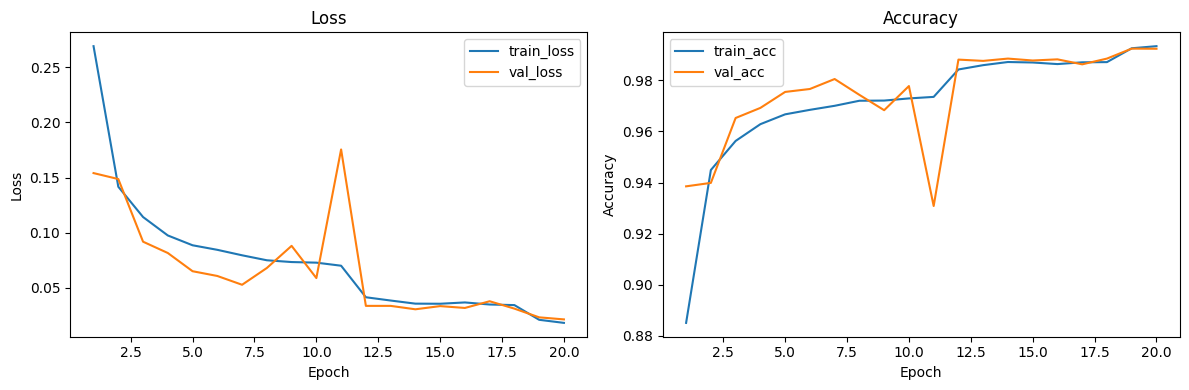

✅ Loaded model from: /kaggle/working/saved_models/best_resnet18.pth


Testing:   0%|          | 0/625 [00:00<?, ?it/s]


✅ Test Accuracy: 99.22%

Classification Report:
              precision    recall  f1-score   support

        fake     0.9938    0.9905    0.9921     10000
        real     0.9905    0.9938    0.9922     10000

    accuracy                         0.9921     20000
   macro avg     0.9922    0.9922    0.9921     20000
weighted avg     0.9922    0.9921    0.9921     20000

Confusion Matrix:
 [[9905   95]
 [  62 9938]]
ROC AUC (class 1): 0.9997


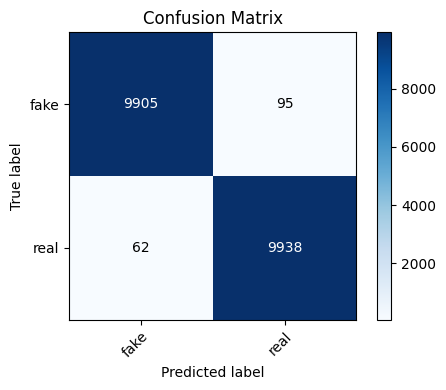

✅ Saved predictions to: /kaggle/working/saved_models/test_predictions.csv


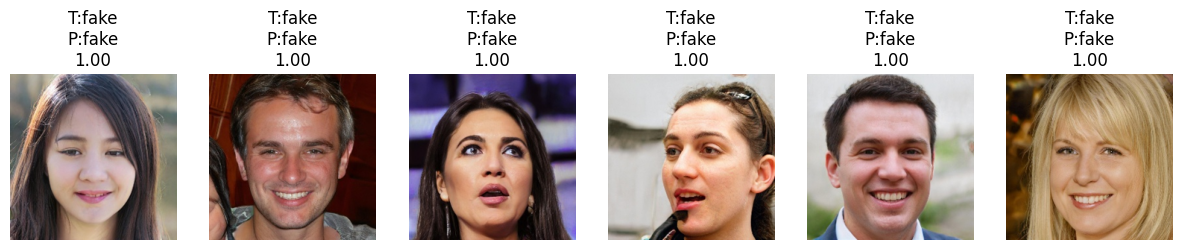

In [15]:
# =====================================================
# STEP 7 — PLOT CURVES, LOAD BEST MODEL & EVALUATE ON TEST
# =====================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import torch

# ---------- Helper: load best checkpoint robustly ----------
def load_state_dict_flexible(model, state_dict_path):
    """
    Load state dict handling possible 'module.' prefix (DataParallel) differences.
    """
    sd = torch.load(state_dict_path, map_location=DEVICE)
    if not isinstance(sd, dict):
        # saved raw state_dict
        state_dict = sd
    else:
        # saved dict may contain extras (like epoch or optimizer). try to find model_state_dict
        if 'model_state_dict' in sd:
            state_dict = sd['model_state_dict']
        elif 'state_dict' in sd:
            state_dict = sd['state_dict']
        else:
            state_dict = sd

    # fix prefix mismatch
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k
        if k.startswith("module.") and not any(x.startswith("module.") for x in model.state_dict().keys()):
            new_key = k[len("module."):]
        if not k.startswith("module.") and any(x.startswith("module.") for x in model.state_dict().keys()):
            new_key = "module." + k
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    return model

# ---------- Plot training curves ----------
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# show curves (if history exists)
try:
    plot_history(history)
except Exception as e:
    print("No history to plot:", e)

# ---------- Load best model ----------
best_path = os.path.join(SAVE_DIR, f"best_{MODEL_NAME}.pth")
if not os.path.exists(best_path):
    # fallback: maybe saved as plain state dict at different name
    # attempt to find any saved model in SAVE_DIR
    files = os.listdir(SAVE_DIR)
    if files:
        best_path = os.path.join(SAVE_DIR, files[0])
        print("Using fallback model:", best_path)
    else:
        raise FileNotFoundError(f"No model found in {SAVE_DIR}. Train and save a model first.")

# create a fresh model object and load weights
eval_model = get_resnet(MODEL_NAME, PRETRAINED, num_classes=2).to(DEVICE)
# wrap with DataParallel if original model used it
if torch.cuda.device_count() > 1:
    eval_model = torch.nn.DataParallel(eval_model)

eval_model = load_state_dict_flexible(eval_model, best_path)
eval_model.eval()
print("✅ Loaded model from:", best_path)

# ---------- Evaluate on test set and collect predictions ----------
all_probs = []
all_preds = []
all_targets = []
all_paths = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        # forward (no amp needed)
        outputs = eval_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# flatten
all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# optional: try to recover image file paths from dataset (works if test_ds is ImageFolder, not a Subset)
image_paths = []
try:
    if hasattr(test_ds, "samples"):
        image_paths = [p for (p, _) in test_ds.samples]
    elif hasattr(test_ds, "dataset") and hasattr(test_ds.dataset, "samples"):
        # if test_ds is a Subset
        image_paths = [test_ds.dataset.samples[i][0] for i in test_ds.indices]
except Exception:
    image_paths = ["-"] * len(all_preds)

# ---------- Metrics ----------
acc = (all_preds == all_targets).mean()
print(f"\n✅ Test Accuracy: {acc*100:.2f}%\n")

target_names = test_ds.classes if hasattr(test_ds, "classes") else ['fake', 'real']
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:\n", cm)

# compute ROC AUC for binary task (requires probs of positive class)
if all_probs.shape[1] == 2:
    try:
        # assume class index 1 is 'real' (ImageFolder sorts class names alphabetically)
        auc = roc_auc_score(all_targets, all_probs[:,1])
        print(f"ROC AUC (class 1): {auc:.4f}")
    except Exception as e:
        print("Could not compute ROC AUC:", e)

# ---------- Plot confusion matrix ----------
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label',
           xlabel='Predicted label',
           title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, target_names)

# ---------- Save predictions to CSV ----------
pred_df = pd.DataFrame({
    "image_path": image_paths[:len(all_preds)],
    "true_label": [target_names[int(t)] for t in all_targets],
    "pred_label": [target_names[int(p)] for p in all_preds],
    "prob_class_0": all_probs[:,0],
    "prob_class_1": all_probs[:,1],
})
csv_path = os.path.join(SAVE_DIR, "test_predictions.csv")
pred_df.to_csv(csv_path, index=False)
print("✅ Saved predictions to:", csv_path)

# ---------- Show a few example images with preds ----------
try:
    from PIL import Image, ImageFont, ImageDraw
    n_show = min(6, len(all_preds))
    fig, axes = plt.subplots(1, n_show, figsize=(15, 5))
    for i in range(n_show):
        img_path = image_paths[i]
        img = Image.open(img_path).convert("RGB")
        axes[i].imshow(img.resize((224,224)))
        axes[i].axis('off')
        axes[i].set_title(f"T:{target_names[all_targets[i]]}\nP:{target_names[all_preds[i]]}\n{all_probs[i, all_preds[i]]:.2f}")
    plt.show()
except Exception as e:
    print("Could not display sample images:", e)
